In [2]:
import os
import glob
import monai
import torch
import numpy as np 
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel 
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)

In [3]:
data_dir = './dataset_512/3d_images'
images = sorted(
    glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


In [4]:
base_dir = './dataset_512'
datasets = ['train', 'val', 'test']
data_types = ['2d_images', '2d_masks']

# Create directories
dir_paths = {}
for dataset in datasets:
    for data_type in data_types:
        # Construct the directory path
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}_512')
        dir_paths[f'{dataset}_{data_type}_512'] = dir_path
        # Create the directory
        os.makedirs(dir_path, exist_ok=True)

# Assuming first 2 patients for training, next 1 for validation and last 1 for testing
for idx, (img_path, mask_path) in enumerate(zip(images, labels)):
    # Load the 3D image and mask
    img = sitk.ReadImage(img_path)
    mask = sitk.ReadImage(mask_path)

    print('processing patient', idx, img.GetSize(), mask.GetSize())

    # Get the mask data as numpy array
    mask_data = sitk.GetArrayFromImage(mask)

    # Select appropriate directories
    if idx < 2:  # Training
        img_dir = dir_paths['train_2d_images_512']
        mask_dir = dir_paths['train_2d_masks_512']
    elif idx == 2:  # Validation
        img_dir = dir_paths['val_2d_images_512']
        mask_dir = dir_paths['val_2d_masks_512']
    else:  # Testing
        img_dir = dir_paths['test_2d_images_512']
        mask_dir = dir_paths['test_2d_masks_512']

    # Iterate over the axial slices
    for i in range(img.GetSize()[0]):
        # If the mask slice is not empty, save the image and mask slices

#         if np.any(mask_data[i, :, :]):
            # Prepare the new ITK images
            img_slice = img[i, :, :]
            mask_slice = mask[i, :, :]
            
            # Define the output paths
            img_slice_path = os.path.join(img_dir, f"{os.path.basename(img_path).replace('.nii.gz', '')}_{i}.nii.gz")
            mask_slice_path = os.path.join(mask_dir, f"{os.path.basename(mask_path).replace('.nii.gz', '')}_{i}.nii.gz")

            # Save the slices as NIfTI files
            sitk.WriteImage(img_slice, img_slice_path)
            sitk.WriteImage(mask_slice, mask_slice_path)            
            

processing patient 0 (325, 512, 512) (325, 512, 512)
processing patient 1 (465, 512, 512) (465, 512, 512)
processing patient 2 (301, 512, 512) (301, 512, 512)
processing patient 3 (117, 512, 512) (117, 512, 512)


In [5]:
# create an instance of the processor for image preprocessing
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")
# processor

In [6]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 512, 512] # if there is no mask in the array, set bbox to image size

In [7]:
from monai.transforms import ResizeD


class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transforms = transforms = Compose([
            
            # load .nii or .nii.gz files
            LoadImaged(keys=['img', 'label']),
            
            # add channel id to match PyTorch configurations
            EnsureChannelFirstd(keys=['img', 'label']),
            
            # reorient images for consistency and visualization
            Orientationd(keys=['img', 'label'], axcodes='RA'),
            
            # resample all training images to a fixed spacing
#             Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),
            
            # rescale image and label dimensions to 256x256 
#             CenterSpatialCropd(keys=['img', 'label'], roi_size=(256,256)),
            ResizeD(keys=['img', 'label'], spatial_size=(256,256), mode=("bilinear", "nearest")),
            
            # scale intensities to 0 and 255 to match the expected input intensity range
            ScaleIntensityRanged(keys=['img'], a_min=-1000, a_max=2000, 
                         b_min=0.0, b_max=255.0, clip=True), 
            
            ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, 
                         b_min=0.0, b_max=1.0, clip=True), 

#             SpatialPadd(keys=["img", "label"], spatial_size=(256,256))
#             RepeatChanneld(keys=['img'], repeats=3, allow_missing_keys=True)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # create a dict of images and labels to apply Monai's dictionary transforms
        data_dict = self.transforms({'img': image_path, 'label': mask_path})

        # squeeze extra dimensions
        image = data_dict['img'].squeeze()
        ground_truth_mask = data_dict['label'].squeeze()

        # convert to int type for huggingface's models expected inputs
        image = image.astype(np.uint8)

        # convert the grayscale array to RGB (3 channels)
        array_rgb = np.dstack((image, image, image))
        
        # convert to PIL image to match the expected input of processor
        image_rgb = Image.fromarray(array_rgb)
        
        # get bounding box prompt (returns xmin, ymin, xmax, ymax)
        # in this dataset, the contours are -1 so we change them to 1 for label and 0 for background
        ground_truth_mask[ground_truth_mask < 0] = 1
        
        prompt = get_bounding_box(ground_truth_mask)
        
        # prepare image and prompt for the model
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs

In [8]:
# Initialize dictionary for storing image and label paths
data_paths = {}

# Create directories and print the number of images and masks in each
for dataset in datasets:
    for data_type in data_types:
        # Construct the directory path
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}_512')
        
        # Find images and labels in the directory
        files = sorted(glob.glob(os.path.join(dir_path, "*.nii.gz")))
        
        # Store the image and label paths in the dictionary
        data_paths[f'{dataset}_{data_type.split("_")[1]}'] = files

print('Number of training images', len(data_paths['train_images']))
print('Number of validation images', len(data_paths['val_images']))
print('Number of test images', len(data_paths['test_images']))

Number of training images 790
Number of validation images 301
Number of test images 1208


In [9]:
# create train and validation dataloaders
train_dataset = SAMDataset(image_paths=data_paths['train_images'], mask_paths=data_paths['train_masks'], processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = SAMDataset(image_paths=data_paths['val_images'], mask_paths=data_paths['val_masks'], processor=processor)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask torch.Size([256, 256])


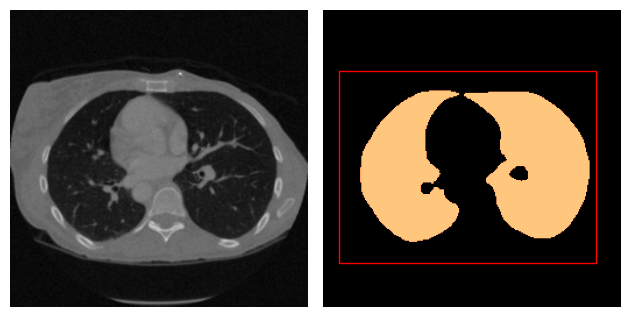

In [10]:
example = train_dataset[50]
for k,v in example.items():
    print(k,v.shape)

xmin, ymin, xmax, ymax = get_bounding_box(example['ground_truth_mask'])

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example['pixel_values'][1], cmap='gray')
axs[0].axis('off')

axs[1].imshow(example['ground_truth_mask'], cmap='copper')

# create a Rectangle patch for the bounding box
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

# add the patch to the second Axes
axs[1].add_patch(rect)

axs[1].axis('off')

plt.tight_layout()
plt.show()

In [88]:
# load the pretrained weights for finetuning
model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder (encoder weights are frozen)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        print(name)
        param.requires_grad_(False)   

vision_encoder.pos_embed
vision_encoder.patch_embed.projection.weight
vision_encoder.patch_embed.projection.bias
vision_encoder.layers.0.layer_norm1.weight
vision_encoder.layers.0.layer_norm1.bias
vision_encoder.layers.0.attn.rel_pos_h
vision_encoder.layers.0.attn.rel_pos_w
vision_encoder.layers.0.attn.qkv.weight
vision_encoder.layers.0.attn.qkv.bias
vision_encoder.layers.0.attn.proj.weight
vision_encoder.layers.0.attn.proj.bias
vision_encoder.layers.0.layer_norm2.weight
vision_encoder.layers.0.layer_norm2.bias
vision_encoder.layers.0.mlp.lin1.weight
vision_encoder.layers.0.mlp.lin1.bias
vision_encoder.layers.0.mlp.lin2.weight
vision_encoder.layers.0.mlp.lin2.bias
vision_encoder.layers.1.layer_norm1.weight
vision_encoder.layers.1.layer_norm1.bias
vision_encoder.layers.1.attn.rel_pos_h
vision_encoder.layers.1.attn.rel_pos_w
vision_encoder.layers.1.attn.qkv.weight
vision_encoder.layers.1.attn.qkv.bias
vision_encoder.layers.1.attn.proj.weight
vision_encoder.layers.1.attn.proj.bias
vision_

In [83]:
# # define training loop
# num_epochs = 30

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
# model.to(device)

# # define optimizer
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# # define segmentation loss with sigmoid activation applied to predictions from the model
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# # track mean train and validation losses
# mean_train_losses, mean_val_losses = [], []

# # create an artibarily large starting validation loss value
# best_val_loss = 100.0
# best_val_epoch = 0

# # set model to train mode for gradient updating
# model.train()
# for epoch in range(num_epochs):
    
#     # create temporary list to record training losses
#     epoch_losses = []
#     for i, batch in enumerate(tqdm(train_dataloader)):

#         # forward pass
#         outputs = model(pixel_values=batch["pixel_values"].to(device),
#                       input_boxes=batch["input_boxes"].to(device),
#                       multimask_output=False)

#         # compute loss
#         predicted_masks = outputs.pred_masks.squeeze(1)
#         ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#         # backward pass (compute gradients of parameters w.r.t. loss)
#         optimizer.zero_grad()
#         loss.backward()

#         # optimize
#         optimizer.step()
#         epoch_losses.append(loss.item())
        
#         # visualize training predictions every 50 iterations
#         if i % 50 == 0:
            
#             # clear jupyter cell output
#             clear_output(wait=True)
            
#             fig, axs = plt.subplots(1, 3)
#             xmin, ymin, xmax, ymax = get_bounding_box(batch['ground_truth_mask'][0])
#             rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

#             axs[0].set_title('input image')
#             axs[0].imshow(batch["pixel_values"][0,1], cmap='gray')
#             axs[0].axis('off')

#             axs[1].set_title('ground truth mask')
#             axs[1].imshow(batch['ground_truth_mask'][0], cmap='copper')
#             axs[1].add_patch(rect)
#             axs[1].axis('off')
            
#             # apply sigmoid
#             medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            
#             # convert soft mask to hard mask
#             medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
#             medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#             axs[2].set_title('predicted mask')
#             axs[2].imshow(medsam_seg, cmap='copper')
#             axs[2].axis('off')

#             plt.tight_layout()
#             plt.show()
    
#     # create temporary list to record validation losses
#     val_losses = []
    
#     # set model to eval mode for validation
#     with torch.no_grad():
#         for val_batch in tqdm(val_dataloader):
            
#             # forward pass
#             outputs = model(pixel_values=val_batch["pixel_values"].to(device),
#                       input_boxes=val_batch["input_boxes"].to(device),
#                       multimask_output=False)
            
#             # calculate val loss
#             predicted_val_masks = outputs.pred_masks.squeeze(1)
#             ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#             val_loss = seg_loss(predicted_val_masks, ground_truth_masks.unsqueeze(1))

#             val_losses.append(val_loss.item())
        
#         # visualize the last validation prediction
#         fig, axs = plt.subplots(1, 3)
#         xmin, ymin, xmax, ymax = get_bounding_box(val_batch['ground_truth_mask'][0])
#         rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

#         axs[0].set_title('input image')
#         axs[0].imshow(val_batch["pixel_values"][0,1], cmap='gray')
#         axs[0].axis('off')

#         axs[1].set_title('ground truth mask')
#         axs[1].imshow(val_batch['ground_truth_mask'][0], cmap='copper')
#         axs[1].add_patch(rect)
#         axs[1].axis('off')

#         # apply sigmoid
#         medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

#         # convert soft mask to hard mask
#         medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
#         medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#         axs[2].set_title('predicted mask')
#         axs[2].imshow(medsam_seg, cmap='copper')
#         axs[2].axis('off')

#         plt.tight_layout()
#         plt.show()

#         # save the best weights and record the best performing epoch
#         if mean(val_losses) < best_val_loss:
#             torch.save(model.state_dict(), f"best_weights_l_v1.pth")
#             print(f"Model Was Saved! Current Best val loss {best_val_loss}")
#             best_val_loss = mean(val_losses)
#             best_val_epoch = epoch
#         else:
#             print("Model Was Not Saved!")
    
#     print(f'EPOCH: {epoch}')
#     print(f'Mean loss: {mean(epoch_losses)}')
    
#     mean_train_losses.append(mean(epoch_losses))
#     mean_val_losses.append(mean(val_losses))

In [84]:
# create test dataloader
test_dataset = SAMDataset(image_paths=data_paths['test_images'], mask_paths=data_paths['test_masks'], processor=processor)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [93]:
import numpy as np
from scipy.ndimage import label, binary_dilation, sum as ndi_sum
import cv2

device = "cuda:1" if torch.cuda.is_available() else "cpu"
state_dict = torch.load("best_weights_l_v2.pth")
model.load_state_dict(state_dict)
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-23): 24 x SamVisionLayer(
        (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

  2%|▏         | 28/1208 [00:01<01:16, 15.52it/s]

  2%|▏         | 30/1208 [00:02<03:07,  6.29it/s]

  3%|▎         | 32/1208 [00:03<06:06,  3.21it/s]

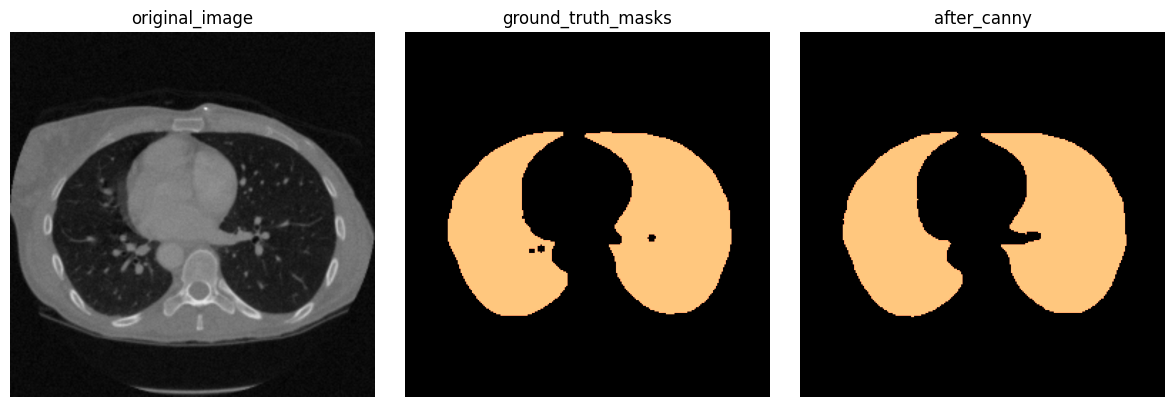

  3%|▎         | 33/1208 [00:04<07:19,  2.67it/s]

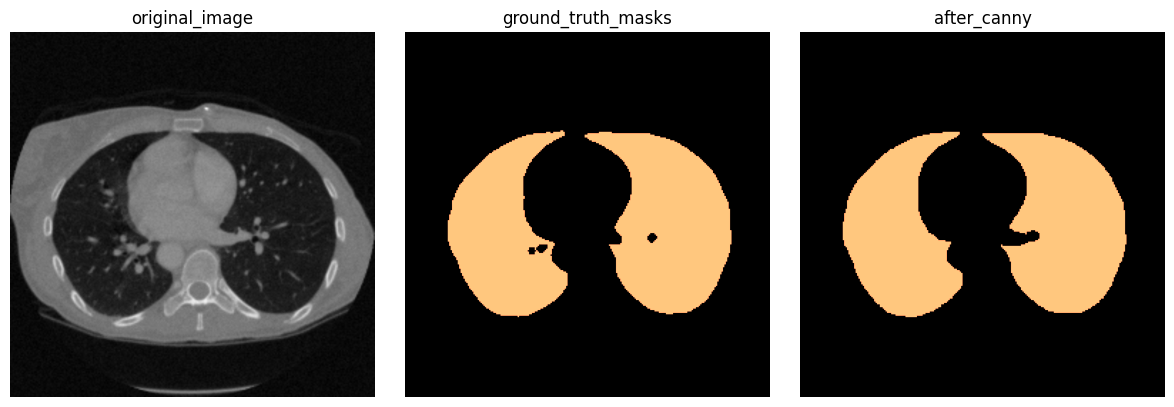

  3%|▎         | 34/1208 [00:05<08:29,  2.31it/s]

  3%|▎         | 35/1208 [00:05<09:29,  2.06it/s]

  3%|▎         | 36/1208 [00:06<10:20,  1.89it/s]

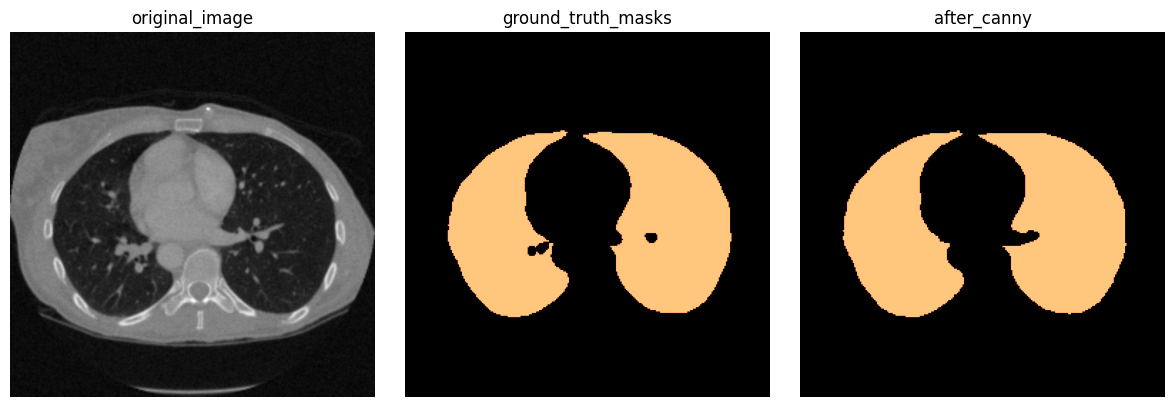

  3%|▎         | 37/1208 [00:07<11:01,  1.77it/s]

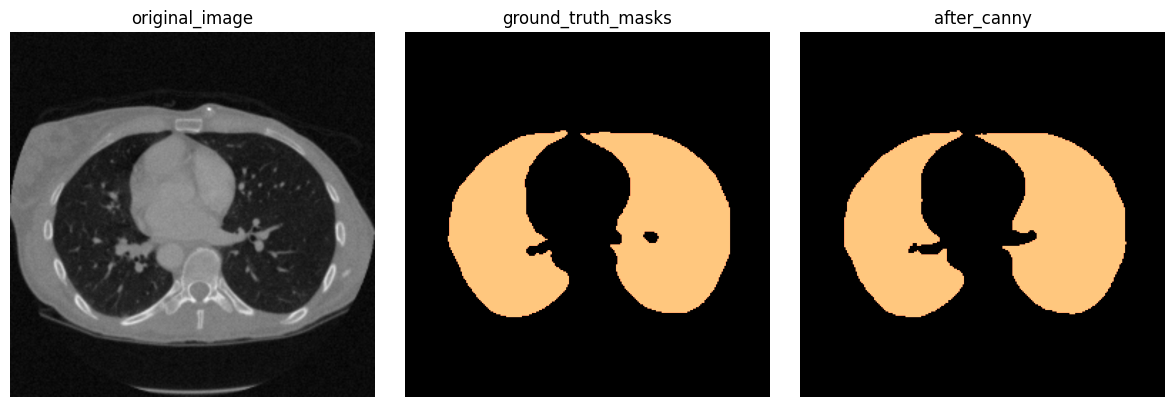

  3%|▎         | 38/1208 [00:07<11:32,  1.69it/s]

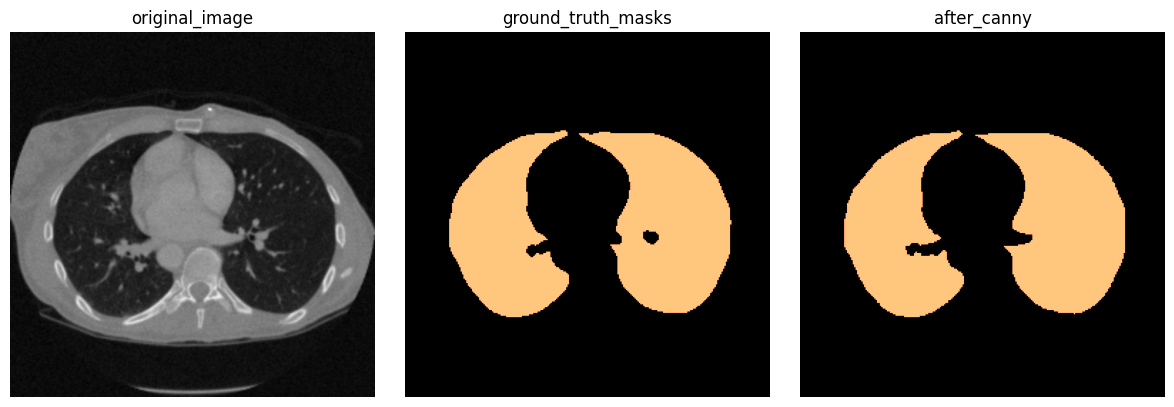

  3%|▎         | 39/1208 [00:08<11:57,  1.63it/s]

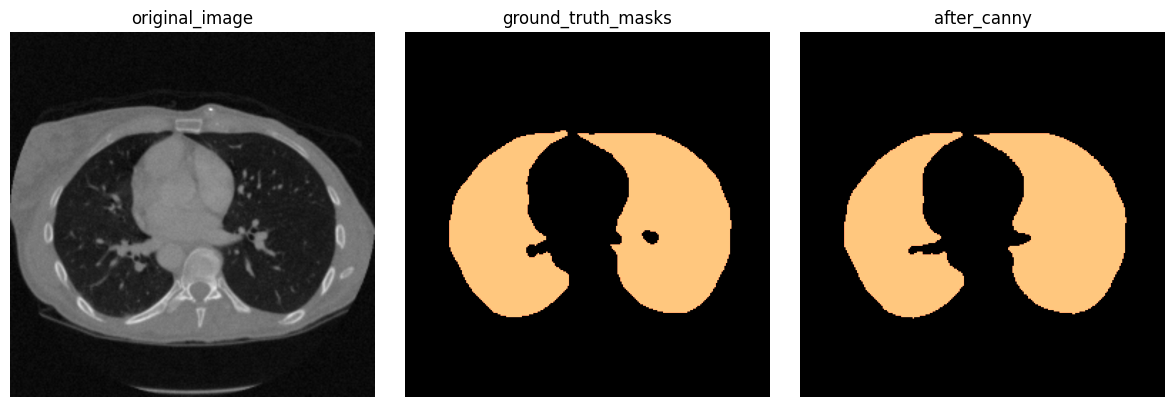

  3%|▎         | 40/1208 [00:09<12:14,  1.59it/s]

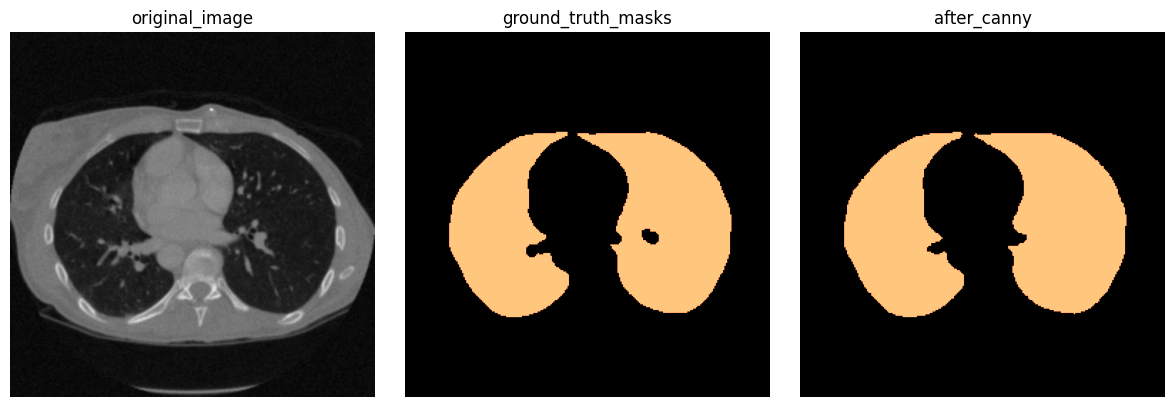

  3%|▎         | 41/1208 [00:09<12:25,  1.57it/s]

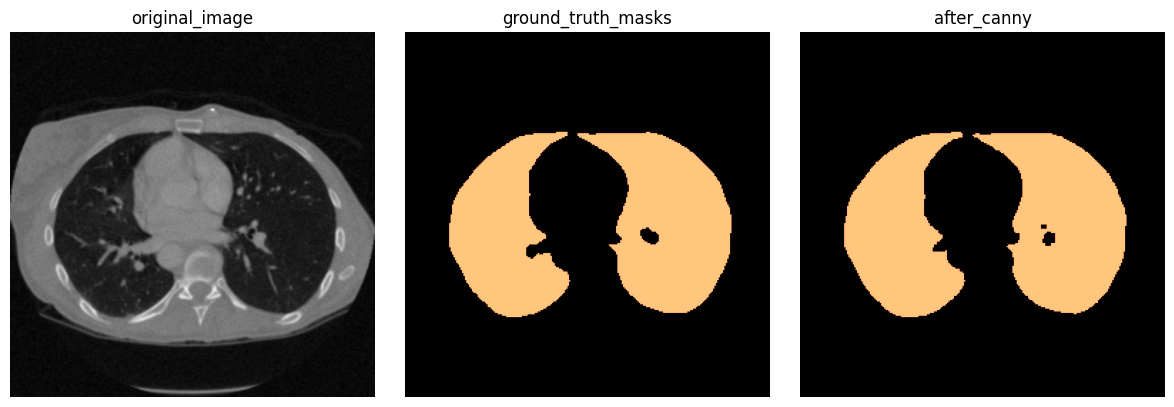

  3%|▎         | 42/1208 [00:10<12:34,  1.54it/s]

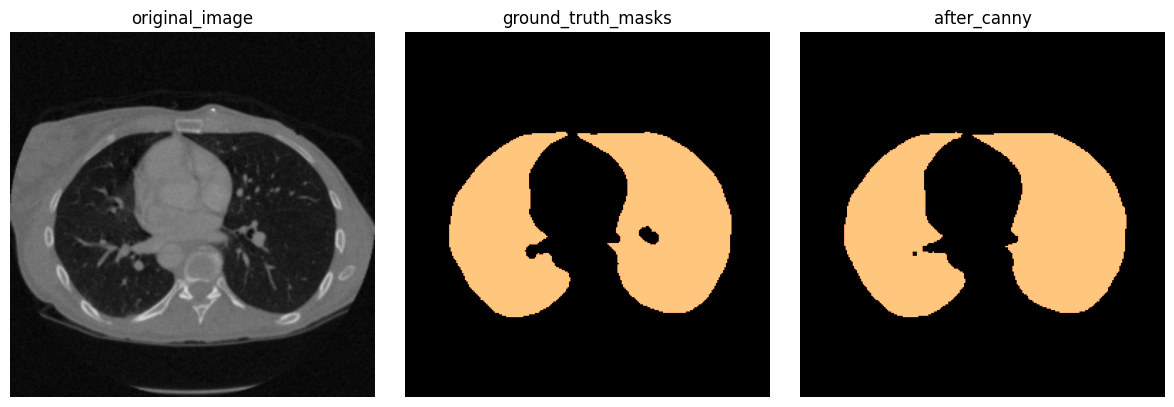

  4%|▎         | 43/1208 [00:11<12:41,  1.53it/s]

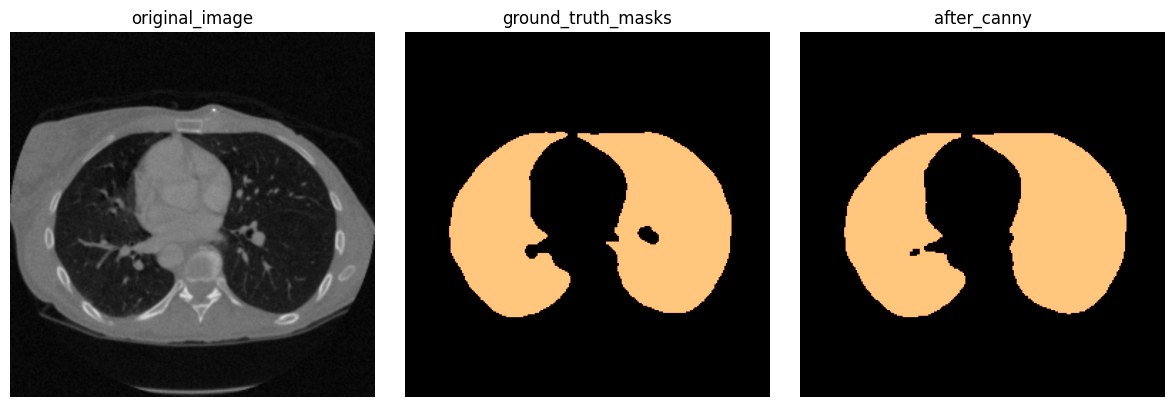

  4%|▎         | 44/1208 [00:11<12:45,  1.52it/s]

  4%|▎         | 45/1208 [00:12<12:47,  1.52it/s]

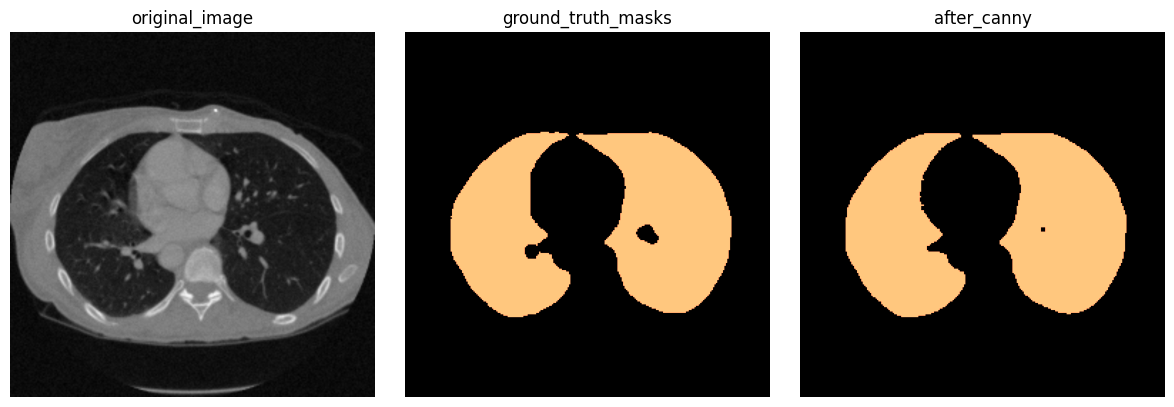

  4%|▍         | 46/1208 [00:13<12:47,  1.51it/s]

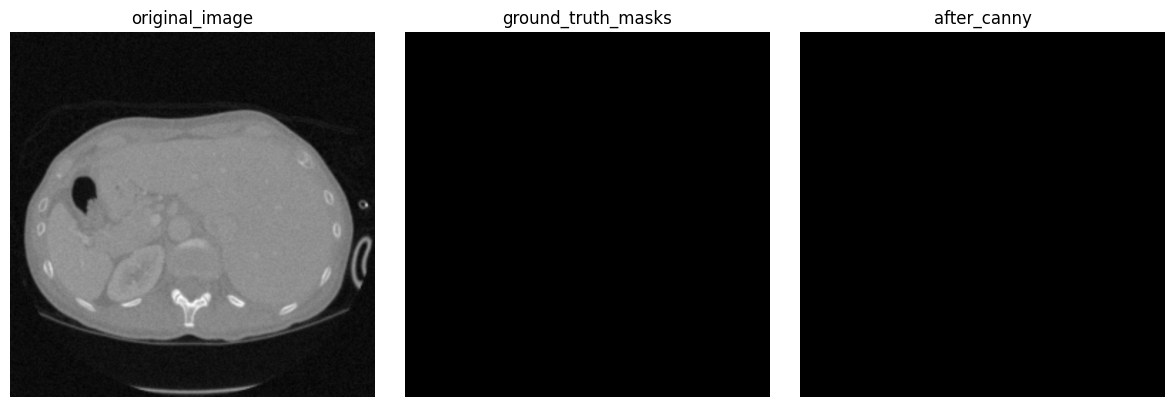

  4%|▍         | 47/1208 [00:13<12:46,  1.51it/s]

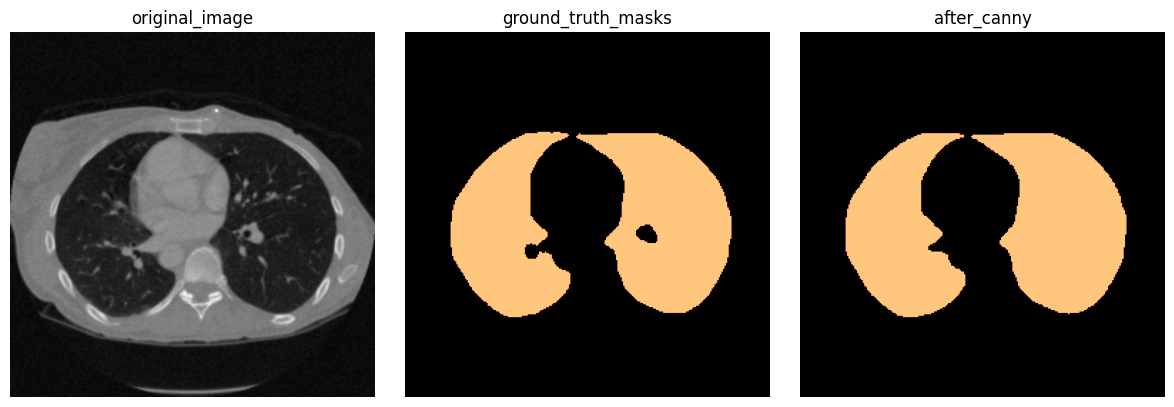

  4%|▍         | 48/1208 [00:14<15:11,  1.27it/s]

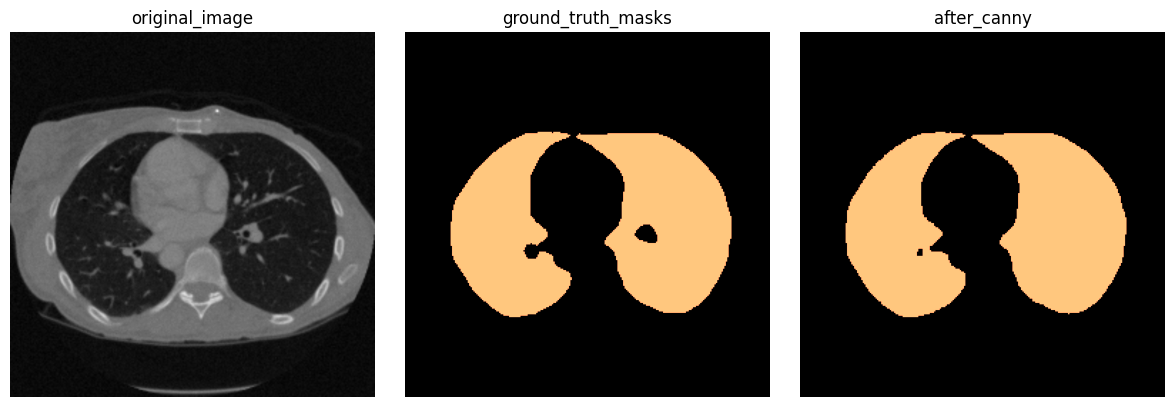

  4%|▍         | 49/1208 [00:15<14:29,  1.33it/s]

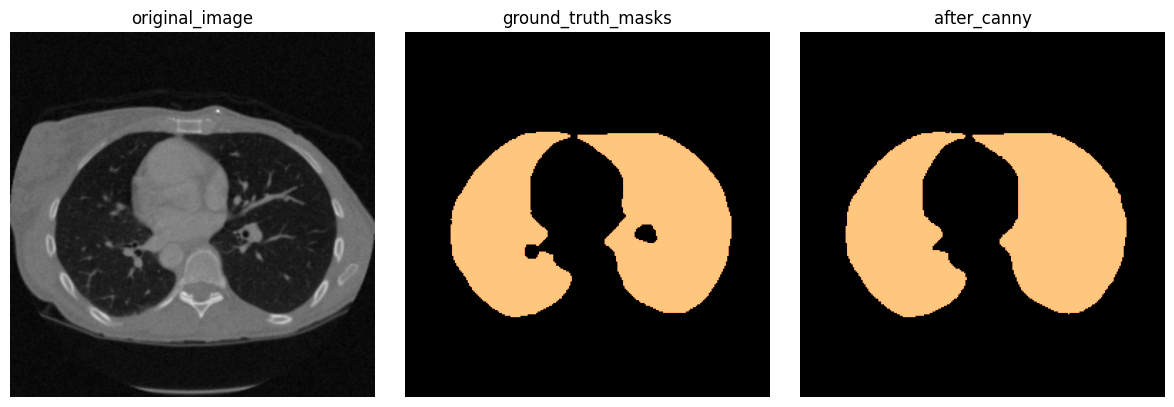

  4%|▍         | 50/1208 [00:16<13:59,  1.38it/s]

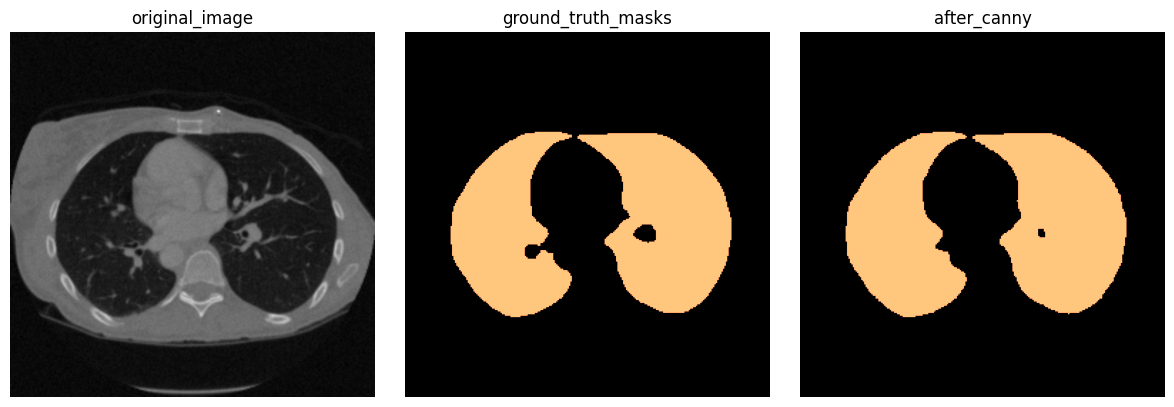

  4%|▍         | 51/1208 [00:16<13:36,  1.42it/s]

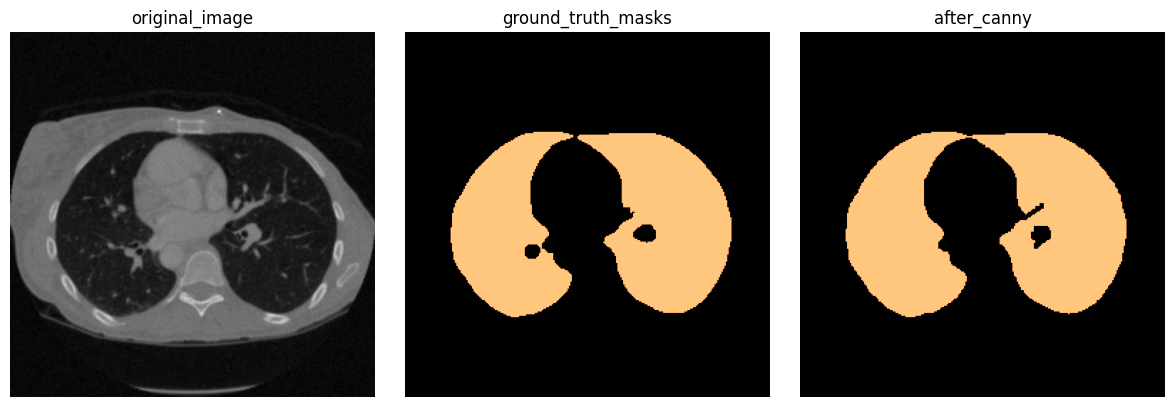

  4%|▍         | 52/1208 [00:17<13:23,  1.44it/s]

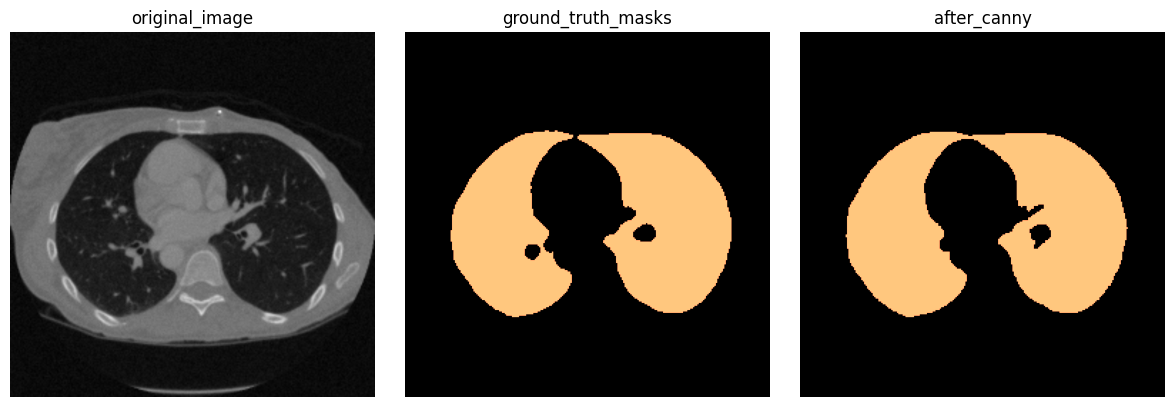

  4%|▍         | 53/1208 [00:18<13:14,  1.45it/s]

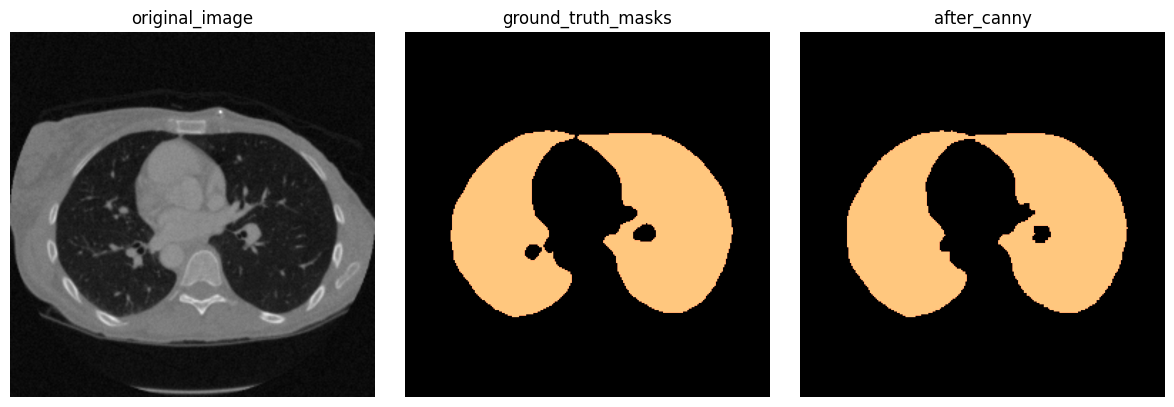

  4%|▍         | 54/1208 [00:18<13:07,  1.46it/s]

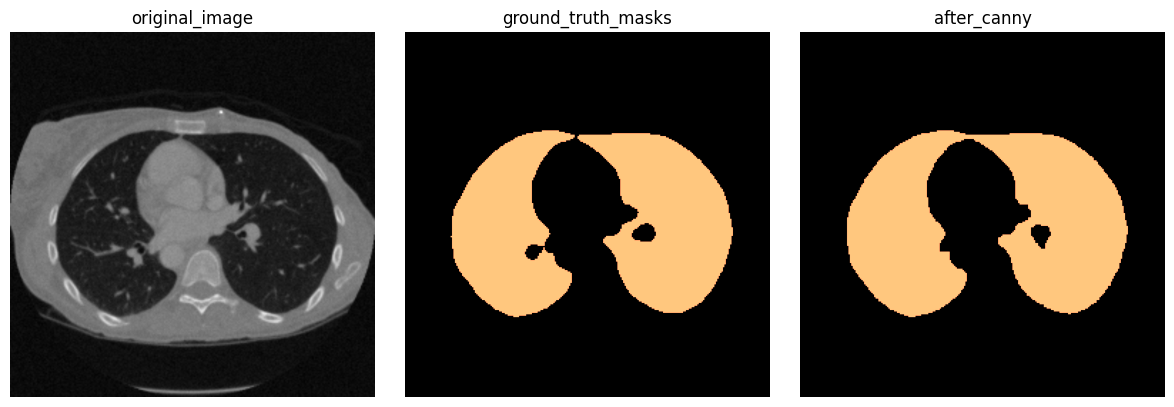

  5%|▍         | 55/1208 [00:19<13:04,  1.47it/s]

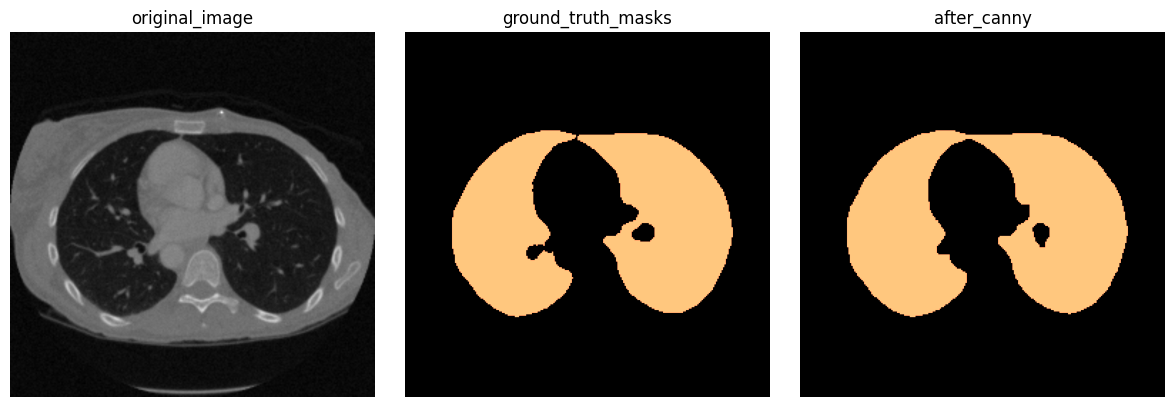

  5%|▍         | 55/1208 [00:20<07:05,  2.71it/s]


In [94]:
with torch.no_grad():
    cnt=0
    for batch in tqdm(test_dataloader):
        cnt+=1
        if cnt<30:
            continue
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].cuda(1),
                      input_boxes=batch["input_boxes"].cuda(1),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().cuda(1)

        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        
        # Remove regions connected to the image border
        labeled, num_features = label(medsam_seg)
        border_mask = np.zeros_like(medsam_seg)
        border_mask[:, 0] = 1
        border_mask[0, :] = 1
        border_mask[:, -1] = 1
        border_mask[-1, :] = 1

        touching_border = np.unique(labeled * binary_dilation(border_mask))
        for region in touching_border:
            if region != 0:
                medsam_seg[labeled == region] = 0
               
        # plt.imshow(batch["pixel_values"][0, 1], cmap='gray')
        # plt.show()
        # Visualize the image after preprocessing (before Canny)
        # plt.imshow(medsam_seg, cmap='copper')
        # plt.title('before Canny')
        # plt.show()
        # 使用Canny边缘检测
        original_image = batch["pixel_values"][0, 1].cpu().numpy().astype(np.uint8)

        edges_original = cv2.Canny(original_image, 50, 200)
        # plt.imshow(edges_original, cmap='gray')
        # plt.title('Canny Edges of Original Image')
        # plt.show()

        kernel = np.ones((3,3),np.uint8)
        # closing = cv2.morphologyEx(edges_original, cv2.MORPH_CLOSE, kernel)

        dilated = cv2.dilate(edges_original, kernel, iterations=1)
        # # 显示结果
        # plt.imshow(dilated,cmap='gray')
        # plt.show()
        # 找到所有的轮廓
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # print(contours)

        # 找到最大的轮廓
        max_contour = max(contours, key=cv2.contourArea)
        # filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]


        # 创建一个全黑的图像
        mask = np.zeros_like(edges_original)
        # 在mask上画出最大的轮廓
        cv2.drawContours(mask, [max_contour],-1, (255), thickness=cv2.FILLED)

        # 创建一个比输入图像大2的掩码，用于floodFill函数
        h, w = mask.shape[:2]
        mask_floodfill = np.zeros((h+2, w+2), np.uint8)

        # floodFill函数会改变输入图像，所以我们使用它的副本
        mask_floodfill_copy = mask.copy()

        # 找到一个种子点
        seed_point = (w//2, h//2)

        # 执行floodFill函数，将与种子点连通的区域填充为白色
        cv2.floodFill(mask_floodfill_copy, mask_floodfill, seed_point, 255)

        # 反转floodfill后的结果
        # mask_floodfill_inv = cv2.bitwise_not(mask_floodfill_copy)

        # 结合原始的mask和floodfill的结果，得到最终的mask
        final_mask = mask | mask_floodfill_copy



        final_mask = cv2.resize(final_mask, (256, 256))
        # channels = mask.shape[2] if len(mask.shape) == 3 else 1
        # print(channels)
        # channels = medsam_seg.shape[2] if len(mask.shape) == 3 else 1
        # print(channels)
        # print("--------")
        # Keep regions with area greater than 2*2
        for i in range(1, num_features + 1):
            area = ndi_sum(labeled == i)
            if area <= 4:
                medsam_seg[labeled == i] = 0

        # plt.imshow(final_mask,cmap='gray')
        # plt.title('mask')
        # plt.show()
        # 使用mask去掉落在外边的像素点
        masked_seg = cv2.bitwise_or(medsam_seg,medsam_seg, mask=final_mask)
        closed_seg = cv2.morphologyEx(masked_seg, cv2.MORPH_CLOSE, kernel)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(batch["pixel_values"][0,1], cmap='gray')
        plt.title('original_image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(batch["ground_truth_mask"][0], cmap='copper')
        plt.title('ground_truth_masks')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(closed_seg, cmap='copper')
        plt.title('after_canny')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        
        if cnt>55:
            break
